### Import paczek

In [1]:
include("utils/GlobalUsings.jl")
include("utils/DataLoader.jl")
include("Lib/CustomDiffLib.jl")
include("utils/NetFunctions.jl")
include("utils/Ploter.jl")

plotTestAccuracty (generic function with 1 method)

##  Załadowanie danych

In [2]:
X_train, y_train, X_test, y_test, classes  = getPrepearedData()
nothing

## SIEĆ FLUX

In [107]:
include("nets/netFlux.jl")
fluxNet, opt, loss, params = getDefaultFlux(4)
fluxLossHistory, fluxAccuracyTrainingHistory = trainFlux(fluxNet, params, X_train, y_train, 5, opt, loss)
fluxAccuracyTrainingVal = getTrainingAccValFromHistory(fluxAccuracyTrainingHistory)
fluxAccuracyTestHistory, fluxAccuracyTestVal = getFluxAccuracyValFromTest(fluxNet, X_test, y_test)
nothing

#### Wykresy 

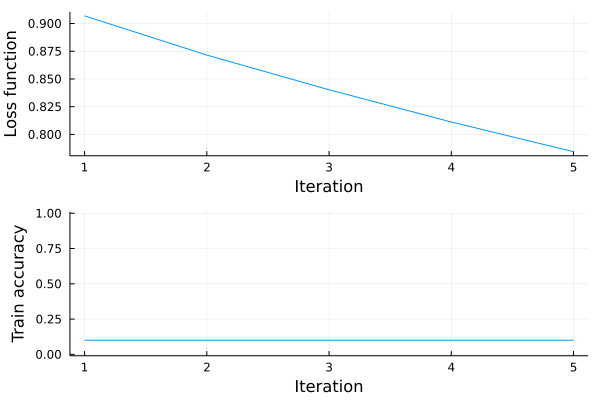

In [108]:
plotLossAccuracy(fluxLossHistory, fluxAccuracyTrainingHistory)

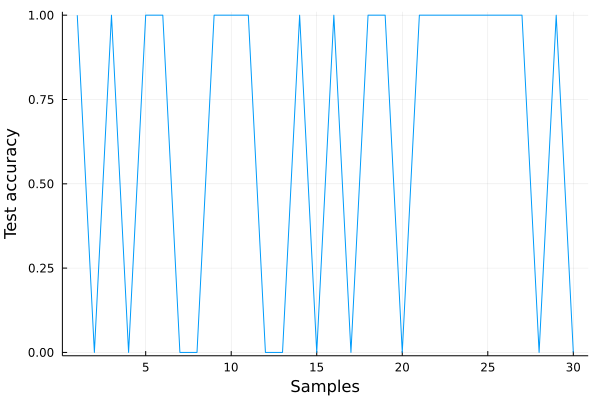

In [36]:
plotTestAccuracty(fluxAccuracyTestHistory)

### Sieć Ani

In [93]:
include("nets/NetAnia.jl")
aniaNet = getDefaultAniaNet(4)
aniaLossHistory, AniaAccHistory = trainAnia(aniaNet, X_train, y_train, 5, 0.01)
aniaAccTrainVal = getTrainingAccValFromHistory(AniaAccHistory)
aniaAccuracyTestHistory, AniaTestAccVal = accuracy(aniaNet, X_test, y_test)
nothing

### Wykresy

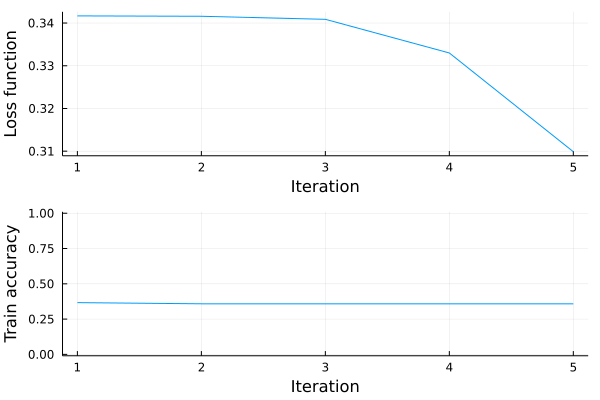

In [94]:
plotLossAccuracy(aniaLossHistory, AniaAccHistory)

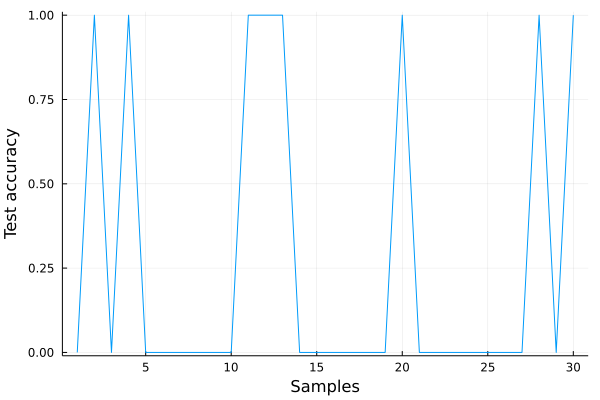

In [95]:
plotTestAccuracty(aniaAccuracyTestHistory)

## Sieć Sebastiana

In [96]:
include("nets/netSebastian.jl")
sebastianNet = getSebastianDefaultNet(4)
sebastianTrainLoss, sebastianTrainAccHistory = trainSebastian(sebastianNet, X_train, y_train, 5, 0.01)

sebastianTrainAccVal = getTrainingAccValFromHistory(sebastianTrainAccHistory)
sebastianTestAccuracy, sebastianTestAccVal = accuracySebastian(sebastianNet, X_test, y_test)
nothing


### Wykresy

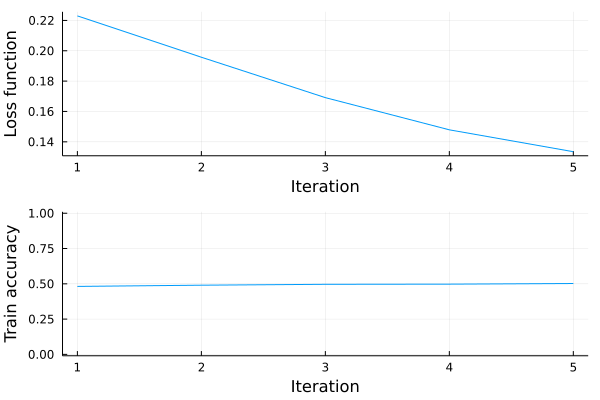

In [97]:
plotLossAccuracy(sebastianTrainLoss, sebastianTrainAccHistory)

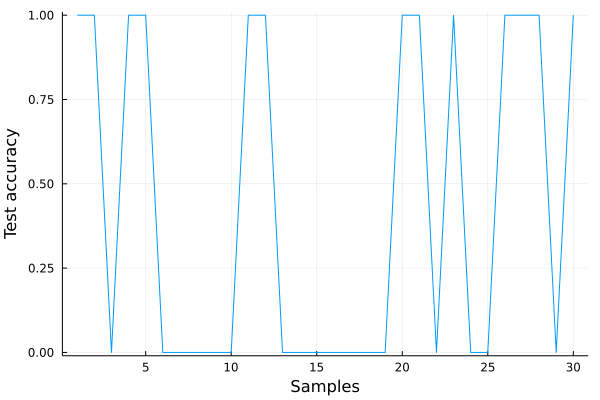

In [98]:
plotTestAccuracty(sebastianTestAccuracy)

In [99]:
df_learning_results = DataFrame(Net=String[], TestAccuracy=Float64[], TrainAccuracy=Float64[], LossFunctionMinimum=Float64[], LossFunctionMaximum=Float64[],LossFunctionStd=Float64[] )
push!(df_learning_results, ("Flux", fluxAccuracyTestVal, fluxAccuracyTrainingVal, minimum(fluxLossHistory), maximum(fluxLossHistory), std(fluxLossHistory)))
push!(df_learning_results, ("Ania", AniaTestAccVal, aniaAccTrainVal, minimum(aniaLossHistory), maximum(aniaLossHistory), std(aniaLossHistory)))
push!(df_learning_results, ("Sebastian", sebastianTestAccVal, sebastianTrainAccVal, minimum(sebastianTrainLoss), maximum(sebastianTrainLoss), std(sebastianTrainLoss)))
println("HIDDEN LAYERS:",3)
print(df_learning_results)

HIDDEN LAYERS:3
3×6 DataFrame
 Row │ Net        TestAccuracy  TrainAccuracy  LossFunctionMinimum  LossFunctionMaximum  LossFunctionStd 
     │ String     Float64       Float64        Float64              Float64              Float64         
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Flux          0.0333333       0.04                 0.689906             0.829675        0.0552538
   2 │ Ania          0.266667        0.36                 0.309876             0.341674        0.0136452
   3 │ Sebastian     0.433333        0.493563             0.133464             0.222988        0.0361268

### Benchmarki trenowania sieci

In [133]:
using BenchmarkTools
include("nets/netFlux.jl")
fluxNet, opt, loss, params = getDefaultFlux(6)
t1 = @benchmark trainFlux(fluxNet, params, X_train, y_train, 10, opt, loss)
include("nets/netAnia.jl")
aniaNet = getDefaultAniaNet(6)
t2 = @benchmark trainAnia(aniaNet, X_train, y_train, 10, 0.01)
include("nets/netSebastian.jl")
sebastianNet = getSebastianDefaultNet(6)
t3 = @benchmark trainSebastian(sebastianNet, X_train, y_train, 10, 0.010)
nothing

### Flux

In [128]:
t1

BenchmarkTools.Trial: 5726 samples with 1 evaluation.
 Range (min … max):  563.500 μs … 40.491 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     666.900 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   865.895 μs ±  1.115 ms  ┊ GC (mean ± σ):  8.63% ± 8.06%

  ▇█▆▄▃▃▂▁▁                                                    ▁
  ████████████▇█▇███████▆▅▅▄▄▅▆▅▄▃▄▄▄▁▃▃▃▄▁▃▁▃▁▁▁▁▃▁▁▁▃▃▁▁▃▁▁▃ █
  564 μs        Histogram: log(frequency) by time      4.66 ms <

 Memory estimate: 1.01 MiB, allocs estimate: 913.

### Ania

In [134]:
t2

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  834.497 ms …    1.502 s  ┊ GC (min … max): 2.22% … 2.72%
 Time  (median):     938.800 ms               ┊ GC (median):    4.25%
 Time  (mean ± σ):      1.026 s ± 249.181 ms  ┊ GC (mean ± σ):  3.32% ± 1.15%

  █  █ █       █       █                                      █  
  █▁▁█▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  834 ms           Histogram: frequency by time           1.5 s <

 Memory estimate: 209.73 MiB, allocs estimate: 2728888.

### Sebastian

In [135]:
t3

BenchmarkTools.Trial: 25 samples with 1 evaluation.
 Range (min … max):  161.009 ms … 314.522 ms  ┊ GC (min … max): 0.00% … 7.09%
 Time  (median):     202.842 ms               ┊ GC (median):    9.77%
 Time  (mean ± σ):   207.097 ms ±  31.743 ms  ┊ GC (mean ± σ):  9.27% ± 3.80%

          █▃ ▃▃      █  █                                        
  ▇▁▁▁▁▁▁▁██▇██▁▇▁▇▁▇█▁▇█▇▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  161 ms           Histogram: frequency by time          315 ms <

 Memory estimate: 112.91 MiB, allocs estimate: 1142607.

In [88]:
include("nets/netAnia.jl")
aniaLossHistory, AniaAccHistory, aniaAccTrainVal, aniaAccuracyTestHistory, AniaTestAccVal = getAniaResults(4, X_train,y_train,X_test,y_test,5,0.01) 


([0.15359788066082566, 0.13647838781177268, 0.1354730048216538, 0.1536269496604719, 0.17687848371204876], [0.16666666666666663, 0.2916666666666667, 0.575, 0.625, 0.6833333333333332], 0.46833333333333327, [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], 0.7666666666666667)

In [89]:
include("nets/netSebastian.jl")
sebastianTrainLoss, sebastianTrainAccHistory, sebastianTrainAccVal, sebastianTestAccuracy, sebastianTestAccVal = getSebastianResults(4, X_train, y_train, X_test, y_test, 5, 0.01) 

([0.11208629622435759, 0.09797337191184956, 0.0917991614817453, 0.08852672260724359, 0.08746281456124817], [0.4525062483125557, 0.448386462962551, 0.5014684319429237, 0.5018174252567522, 0.500979432868119], 0.4810316002685803, [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0], 0.5666666666666667)

In [92]:
include("nets/netFlux.jl")
fluxLossHistory, fluxAccuracyTrainingHistory, fluxAccuracyTrainingVal, fluxAccuracyTestHistory, fluxAccuracyTestVal = getFluxResults(4, X_train, y_train, X_test, y_test, 5, 0.01) 

([0.8296754152579383, 0.7884155354784832, 0.7519257676655067, 0.7192815025048678, 0.689906419939126], [0.03333333333333333, 0.0, 0.03333333333333333, 0.06666666666666667, 0.06666666666666667], 0.04, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.03333333333333333)